# RSI efficiency on Warsaw Stock Exchange based on WIG20

In [1]:
""" append parent dir to sys.path for local imports """
import sys
if '..\\' not in sys.path: sys.path.append('..\\')   

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from stocks.stock import Stock
from stocks.stock_index import wig20, mwig40
from analysis.rsi import rsi, rsi_cross_signals

sns.set()
plt.rcParams['figure.figsize'] = [12, 8]

## Time range of interest

In [2]:
start_date = '2019-01-01'
end_date = '2019-12-31'

time_range = pd.date_range(start_date, end_date)

## Get OHLC information, and calculate RSI and signals

In [3]:
stock_data = pd.DataFrame(columns=['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Norm Close', 'Norm Volume', 'RSI', 'Buy', 'Sell'])

all_tickers = wig20
all_tickers.update(mwig40)

for ticker in all_tickers:
    """ create Stock instance """
    ticker_stock = Stock(ticker)
    
    """ get prices from given time range """
    map_ = ticker_stock.ohlc.index.isin(time_range)
    ticker_data = ticker_stock.ohlc[map_]
    
    ticker_data.insert(0, 'Norm Close', ticker_data['Close'] / ticker_data['Close'].max())
    ticker_data.insert(0, 'Norm Volume', ticker_data['Volume'] / ticker_data['Volume'].max())
    
    """ calculate RSI using all available data """
    ticker_data = ticker_data.join(rsi(ticker_stock.ohlc))
    
    """ find Buy and Sell signals """
    ticker_data['Buy'] = rsi_cross_signals(ticker_data, 20, 'onrise').astype(float)
    ticker_data['Sell'] = rsi_cross_signals(ticker_data, 80, 'onrise').astype(float)
    
    """ insert date and ticker """
    ticker_data.insert(0, 'Ticker', ticker)
    ticker_data.insert(0, 'Date', ticker_data.index)
    
    """ collect data in one table """
    stock_data = stock_data.append(ticker_data, ignore_index=True)
    
stock_data.head()

,Date,Ticker,Open,High,Low,Close,Volume,Norm Close,Norm Volume,RSI,Buy,Sell
0,2019-01-02,ALR,53.15,55.15,52.9,55.00,187429.0,0.860720,0.020062,50.219851,0.0,0.0
1,2019-01-03,ALR,55.00,55.00,53.3,53.40,219807.0,0.835681,0.023528,45.128856,0.0,0.0
2,2019-01-04,ALR,53.90,55.00,53.9,54.75,127074.0,0.856808,0.013602,49.756946,0.0,0.0
3,2019-01-07,ALR,55.05,56.20,54.8,56.20,187654.0,0.879499,0.020086,54.223000,0.0,0.0
4,2019-01-08,ALR,55.65,56.20,54.9,55.95,168800.0,0.875587,0.018068,53.342603,0.0,0.0


In [4]:
stock_data.describe()

,Open,High,Low,Close,Volume,Norm Close,Norm Volume,RSI,Buy,Sell
count,14869.000000,14869.000000,14869.000000,14869.000000,1.486900e+04,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000
mean,232.254091,235.297034,228.858940,232.206004,4.829968e+05,0.803998,0.126958,50.912606,0.001614,0.002488
std,1020.636720,1034.298535,1006.155762,1021.080706,1.312175e+06,0.134136,0.149226,12.089716,0.040145,0.049823
min,0.670000,0.680000,0.660000,0.670000,1.000000e+00,0.282176,0.000002,9.635258,0.000000,0.000000
25%,21.200000,21.528000,20.793000,21.135000,5.474000e+03,0.721815,0.024268,42.841930,0.000000,0.000000
50%,49.599000,49.900000,48.726000,49.509000,4.780300e+04,0.831341,0.078953,51.301664,0.000000,0.000000
75%,144.830000,146.970000,142.690000,144.610000,3.604560e+05,0.909233,0.174865,58.966919,0.000000,0.000000
max,9025.210000,9129.340000,8866.520000,9050.000000,2.782554e+07,1.000000,1.000000,93.291621,1.000000,1.000000


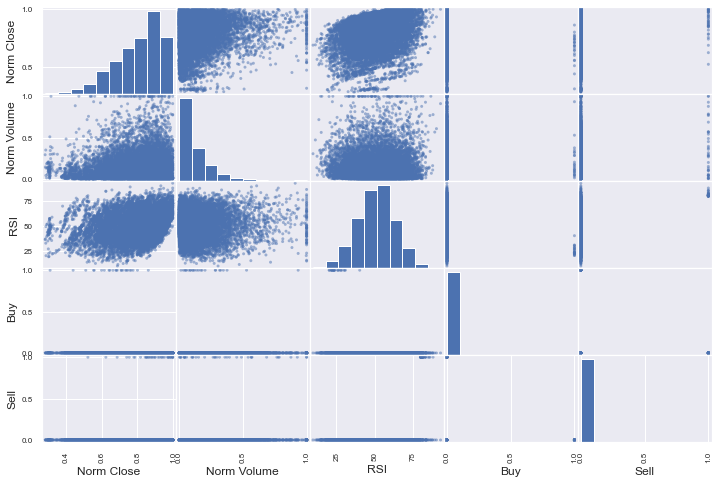

In [5]:
_ = pd.plotting.scatter_matrix(stock_data[['Norm Close', 'Norm Volume', 'RSI', 'Buy', 'Sell']])

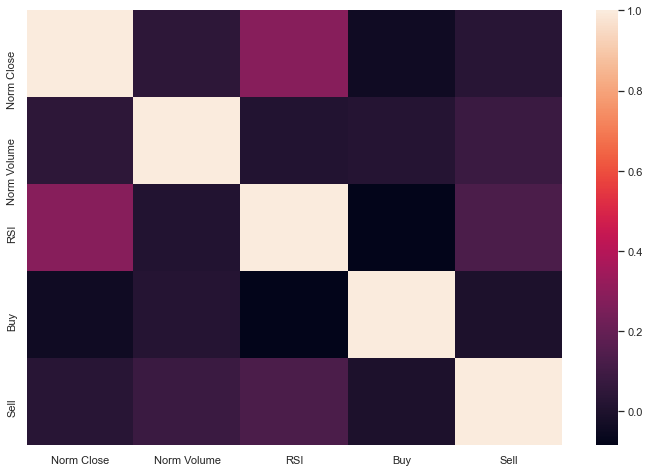

In [6]:
sns.heatmap(stock_data[['Norm Close', 'Norm Volume', 'RSI', 'Buy', 'Sell']].corr())

## Extract close price changes after buy signal

In [7]:
price_change = pd.DataFrame()
  
for ticker in all_tickers:
    ticker_data = stock_data[stock_data['Ticker']==ticker]
    buy_map = ticker_data['Buy'].astype(bool)
    
    """ for each buy signal """
    for buy in ticker_data[buy_map].index:
        
        """ get close price on the day of the signal and 30 following days (31 days together) """
        price_after_buy_signal = ticker_data.loc[buy:].head(91)['Norm Close']
        
        """ reset index and transpose to a row """
        price_after_buy_signal = price_after_buy_signal.reset_index().drop(['index'], axis=1)
        price_after_buy_signal = price_after_buy_signal.transpose()
        
        """ collect all in one DataFrame """
        price_change = price_change.append(price_after_buy_signal, ignore_index=True)
        
price_change.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.734898,0.706103,0.691706,0.676369,0.665102,0.677934,0.659468,0.644444,0.662598,0.659155,...,0.460407,0.445383,0.434742,0.435055,0.440376,0.438811,0.441315,0.435055,0.451643,0.449452
1,0.439750,0.459155,0.469484,0.471674,0.445383,0.441628,0.456964,0.476369,0.471362,0.470423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.710424,0.699632,0.694799,0.700188,0.703610,0.758739,0.760150,0.773659,0.764413,0.729606,...,0.397749,0.425066,0.425966,0.423265,0.421163,0.420863,0.421764,0.420563,0.433171,0.426266
3,0.310094,0.301388,0.287129,0.300188,0.318799,0.351220,0.322702,0.310694,0.307692,0.297186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.740000,0.707857,0.668750,0.695357,0.687500,0.668750,0.667679,0.675357,0.658571,0.670357,...,0.833571,0.837500,0.828571,0.852679,0.861607,0.875536,0.872857,0.852679,0.861607,0.848393


## Calculate relative price change

In [8]:
""" calculate price change relative to the price on the day of the signal """
price_change_relative = price_change.div(price_change.loc[:,0], axis=0)
price_change_relative.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,0.960818,0.941227,0.920358,0.905026,0.922487,0.897359,0.876917,0.901618,0.896934,...,0.626491,0.606048,0.591567,0.591993,0.599233,0.597104,0.600511,0.591993,0.614566,0.611584
1,1.0,1.044128,1.067616,1.072598,1.012811,1.004270,1.039146,1.083274,1.071886,1.069751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.984809,0.978006,0.985591,0.990408,1.068009,1.069995,1.089010,1.075995,1.027001,...,0.559875,0.598327,0.599594,0.595791,0.592834,0.592411,0.593679,0.591989,0.609735,0.600017
3,1.0,0.971926,0.925944,0.968054,1.028074,1.132623,1.040658,1.001936,0.992256,0.958374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.956564,0.903716,0.939672,0.929054,0.903716,0.902268,0.912645,0.889961,0.905888,...,1.126448,1.131757,1.119691,1.152268,1.164334,1.183156,1.179537,1.152268,1.164334,1.146477


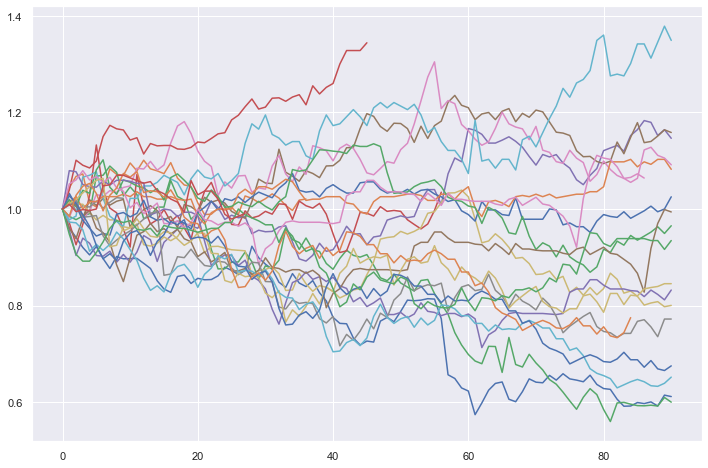

In [9]:
price_change_relative.transpose().plot(legend=False)

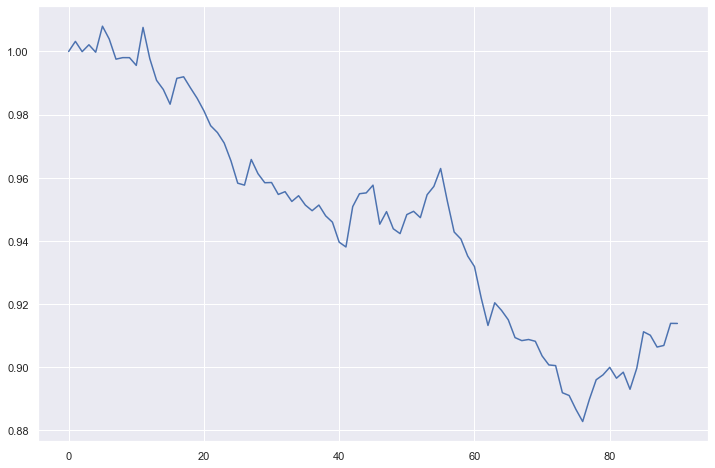

In [10]:
price_change_relative.mean(axis=0).plot(legend=False)